SCENIC + works with both scRNA seq data and ATAC seq data to build the gene regulatory network when we have multiome data. 
Using dnmt3a_tet2 mutated data 

In [1]:
print("You can do it Sanketh")

You can do it Sanketh


In [2]:
#Importing the modules  
import numpy as np
import pandas as pd
import matplotlib as pl
import scanpy as sc
import igraph
import loompy as lp
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import pyscenic
import os



In [3]:
X = io.mmread("../proj1_tet_dnmt3a_mut/data/week30/anndata/matrix.mtx")

In [4]:
adata = anndata.AnnData(X = X.transpose().tocsr())

In [5]:
adata

AnnData object with n_obs × n_vars = 16496 × 28692

In [6]:
metadata = pd.read_csv("../proj1_tet_dnmt3a_mut/data/week30/anndata/metadata.csv")

In [7]:
with open("./data/week30/anndata/gene_names.csv", 'r') as f:
    gene_names = f.read().splitlines


In [8]:
features = pd.read_csv("./data/week30/anndata/gene_names.csv",)

In [9]:
adata.obs = metadata
adata.obs.index = adata.obs['barcode']
adata.var.index = gene_names

TypeError: 'builtin_function_or_method' object is not iterable

In [10]:
adata.var_names = features['gene']

In [11]:
adata
adata.obs_names
adata.var_names

Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1.1', 'Sox17', 'Gm37323',
       'Mrpl15', 'Lypla1', 'Gm37988',
       ...
       'AC125149.1', 'AC125149.2', 'AC125149.4', 'AC234645.1', 'AC168977.2',
       'AC168977.1', 'PISD', 'DHRSX', 'Vmn2r122', 'CAAA01147332.1'],
      dtype='object', name='gene', length=28692)

In [12]:
pca = pd.read_csv("./data/week30/anndata/pca.csv")
pca.index = adata.obs.index

In [13]:
adata.obsm['X_pca'] = pca.to_numpy()
adata.obsm['X_umap'] = np.vstack((adata.obs['UMAP_1'].to_numpy(),
                                  adata.obs['UMAP_2'].to_numpy())).T

In [14]:
adata

AnnData object with n_obs × n_vars = 16496 × 28692
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cellbarcode', 'sample_geo', 'week', 'mutation', 'genotype', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.7', 'seurat_clusters', 'pANN_0.25_0.09_510', 'DF.classifications_0.25_0.09_510', 'genotype_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'harmony_1', 'harmony_2'
    obsm: 'X_pca', 'X_umap'

In [15]:
rna = adata

In [16]:
sc.pp.log1p(rna)

In [17]:
sc.pp.highly_variable_genes(rna, flavor = "seurat")

In [18]:
rna

AnnData object with n_obs × n_vars = 16496 × 28692
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cellbarcode', 'sample_geo', 'week', 'mutation', 'genotype', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.7', 'seurat_clusters', 'pANN_0.25_0.09_510', 'DF.classifications_0.25_0.09_510', 'genotype_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'harmony_1', 'harmony_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'

In [19]:
sc.set_figure_params(facecolor="white")

/Users/sanketh/opt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/sanketh/opt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


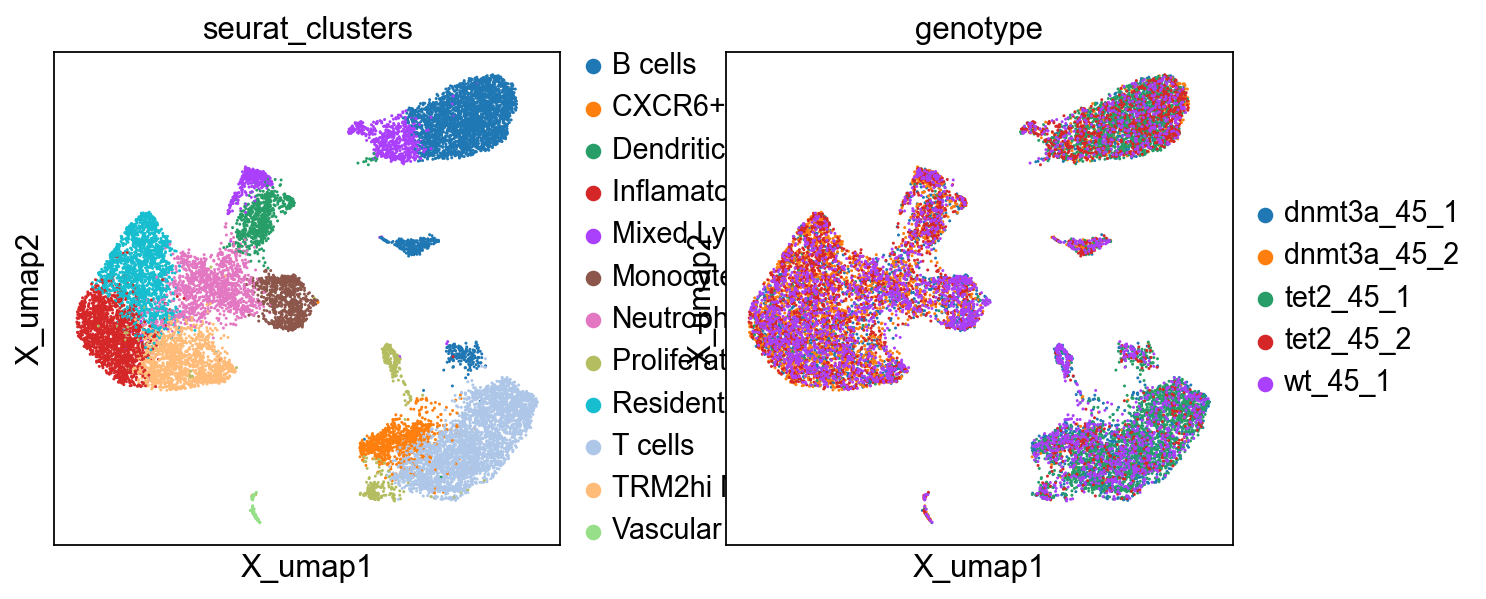

In [20]:
sc.pl.embedding(rna, "X_umap", color=["seurat_clusters", "genotype"])

Preperation for scenic : Need to make a loom file for this 

In [21]:
tfs_path = "./mm_mgi_tfs.txt"

In [22]:
loom_path = "./data/week30/pyscenic/input.loom"
loom_path_output = "./data/week30/pyscenic/output.loom"
tfs = [tf.strip() for tf in open(tfs_path)]

Its a good idea to check if the transcription factors are matching in the gene list in general atleast more than 50 percent should match

In [23]:
# as a general QC. We inspect that our object has transcription factors listed in our main annotations.
print(
    f"%{np.sum(rna.var.index.isin(tfs))} out of {len(tfs)} TFs are found in the object"
)

%1688 out of 1721 TFs are found in the object


Usage of only highly variable genes

In [24]:
rna = adata

Creating a loom file now to prepare for scenic

In [25]:
#Subsampling the anndata object with the highly variable genes to get a setup the scenic workflow in python
sc.pp.subsample(rna,n_obs = 300 )

In [26]:
rna

AnnData object with n_obs × n_vars = 300 × 28692
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cellbarcode', 'sample_geo', 'week', 'mutation', 'genotype', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.7', 'seurat_clusters', 'pANN_0.25_0.09_510', 'DF.classifications_0.25_0.09_510', 'genotype_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'harmony_1', 'harmony_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'seurat_clusters_colors', 'genotype_colors'
    obsm: 'X_pca', 'X_umap'

In [27]:
rna.obs_names

Index(['GAGCAGAAGCGCTCCA-1_GSM7056036_30week_tet2_45_2',
       'CCTATTAGTTCCAACA-1_GSM7056035_30week_tet2_45_1',
       'CTTCTCTAGCGTTTAC-1_GSM7056036_30week_tet2_45_2',
       'CAGCCGAAGAAACCTA-1_GSM7056033_30week_dnmt3a_45_1',
       'GACGTGCAGTGAACGC-1_GSM7056037_30week_wt_45_1',
       'ACTGTCCCATCCTTGC-1_GSM7056037_30week_wt_45_1',
       'TCGCGAGGTGATGCCC-1_GSM7056037_30week_wt_45_1',
       'AAGGCAGGTAAATGAC-1_GSM7056035_30week_tet2_45_1',
       'CATCCACTCCGCAGTG-1_GSM7056034_30week_dnmt3a_45_2',
       'ATCACGAAGGTAGCTG-1_GSM7056037_30week_wt_45_1',
       ...
       'CGCTATCAGATGGGTC-1_GSM7056034_30week_dnmt3a_45_2',
       'AGGTCCGAGTGGTAAT-1_GSM7056036_30week_tet2_45_2',
       'ATGGGAGAGGAACTGC-1_GSM7056035_30week_tet2_45_1',
       'GATCGATCATGGATGG-1_GSM7056034_30week_dnmt3a_45_2',
       'AGCGGTCGTTGTCTTT-1_GSM7056033_30week_dnmt3a_45_1',
       'TGGCTGGCATCAGTCA-1_GSM7056035_30week_tet2_45_1',
       'GTTACAGCATCAGTAC-1_GSM7056035_30week_tet2_45_1',
       'CAGATCAAGA

In [28]:
#Keeping only the highly variable genes
mask = (rna.var["highly_variable"] == True)
rna = rna[:, mask]

In [29]:
rna

View of AnnData object with n_obs × n_vars = 300 × 1237
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cellbarcode', 'sample_geo', 'week', 'mutation', 'genotype', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.7', 'seurat_clusters', 'pANN_0.25_0.09_510', 'DF.classifications_0.25_0.09_510', 'genotype_clusters', 'barcode', 'UMAP_1', 'UMAP_2', 'harmony_1', 'harmony_2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'seurat_clusters_colors', 'genotype_colors'
    obsm: 'X_pca', 'X_umap'

In [30]:
row_attributes = {
    "Gene": np.array(rna.var.index),
}
col_attributes = {
    "CellID": np.array(rna.obs.index),
    "nGene": np.array(np.sum(rna.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(rna.X.transpose(), axis=0)).flatten(),
}

lp.create(loom_path, rna.X.transpose(), row_attributes, col_attributes)

Once the loom file has been generated, we execute pyscenic to generate associations between TFs and genes. TF-gene associations are inferred by GRNBoost, and summarized by a directional weight between TFs and target genes. The output of this analysis is a table summarizing all reported associations with their importance weight.

Some steps below require indicating a number of cores (num_workers). Increase according to computing resources available

In [31]:
num_workers = 1

In [32]:
outpath_adj = "adj.csv"
if not os.path.exists(outpath_adj):
    !pyscenic grn {loom_path} {tfs_path} -o $outpath_adj --num_workers {num_workers}

In [33]:
results_adjacencies = pd.read_csv("adj.csv", index_col=False, sep=",")
print(f"Number of associations: {results_adjacencies.shape[0]}")
results_adjacencies.head()

Number of associations: 61958


,TF,target,importance
0,Ebf1,Ms4a1,14.381110
1,Jun,Sln,14.330116
2,Ikzf3,Cd163l1,13.757061
3,Ebf1,H2-DMb2,12.021445
4,Irf8,Sept3,11.297640


Visualize the distribution of weights for general inspection of the quantiles and thresholds obtained from pyscenic. As provided by the pyscenic grn step, the importance scores follow a unimodal distribution, with negative/positive values indicating TF-gene associations with less/more importance, respectively. From the right-tail of this distribution, we can recover the most relevant interactions between TFs and potential target genes, supported by gene expression values and the analysis done by pyscenic.

(-10.0, 10.0)

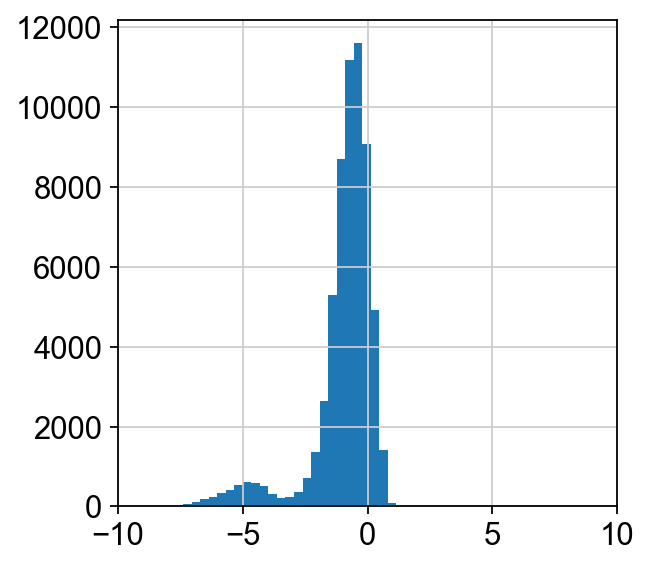

In [34]:
import matplotlib.pyplot as plt
plt.hist(np.log10(results_adjacencies["importance"]), bins=50)
plt.xlim([-10, 10])

As targets genes have DNA motifs at promoters (sequence specific DNA motifs), those can be used to link TFs to target genes. Next, we use an annotation of TF associations to Transcription Start Sites (TSSs) to refine this annotation.

Download TSS annotations precalculated by Aerts’s lab :

In [ ]:
#Motif2tf databases
#wget https://resources.aertslab.org/cistarget/motif2tf/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl
#cisTarget Databse 
#v1 feather files are not supported , use v2 files instead 
#500 bp up and 100bp down
wget https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc_v10_clust/gene_based/mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
#10kb up and down
wget https://resources.aertslab.org/cistarget/databases/mus_musculus/mm10/refseq_r80/mc_v10_clust/gene_based/mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather

In [35]:
#motif databses
motif_path = "../scenic/cisTarget_databases/motif2tf/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"

In [36]:
import glob
import os

# ranking databases
db_glob = "../scenic/cisTarget_databases/mm10_v2/*feather"
db_names = " ".join(glob.glob(db_glob))

In [37]:
db_names

'../scenic/cisTarget_databases/mm10_v2/mm10_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather ../scenic/cisTarget_databases/mm10_v2/mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'

In [40]:
nGenesDetectedPerCell = np.sum(rna.X>0, axis=1)
#Reshape : The number is the number of cells 
a = np.reshape(nGenesDetectedPerCell,300)
a = a.A
a = np.reshape(a,300)
a = pd.Series(a)
percentiles = a.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

0.01     52.0
0.05     61.0
0.10     66.9
0.50    127.0
1.00    396.0
dtype: float64


/var/folders/4n/0z4hxy5s531091hm4l92gjrw0000gn/T/ipykernel_45349/2548705972.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')


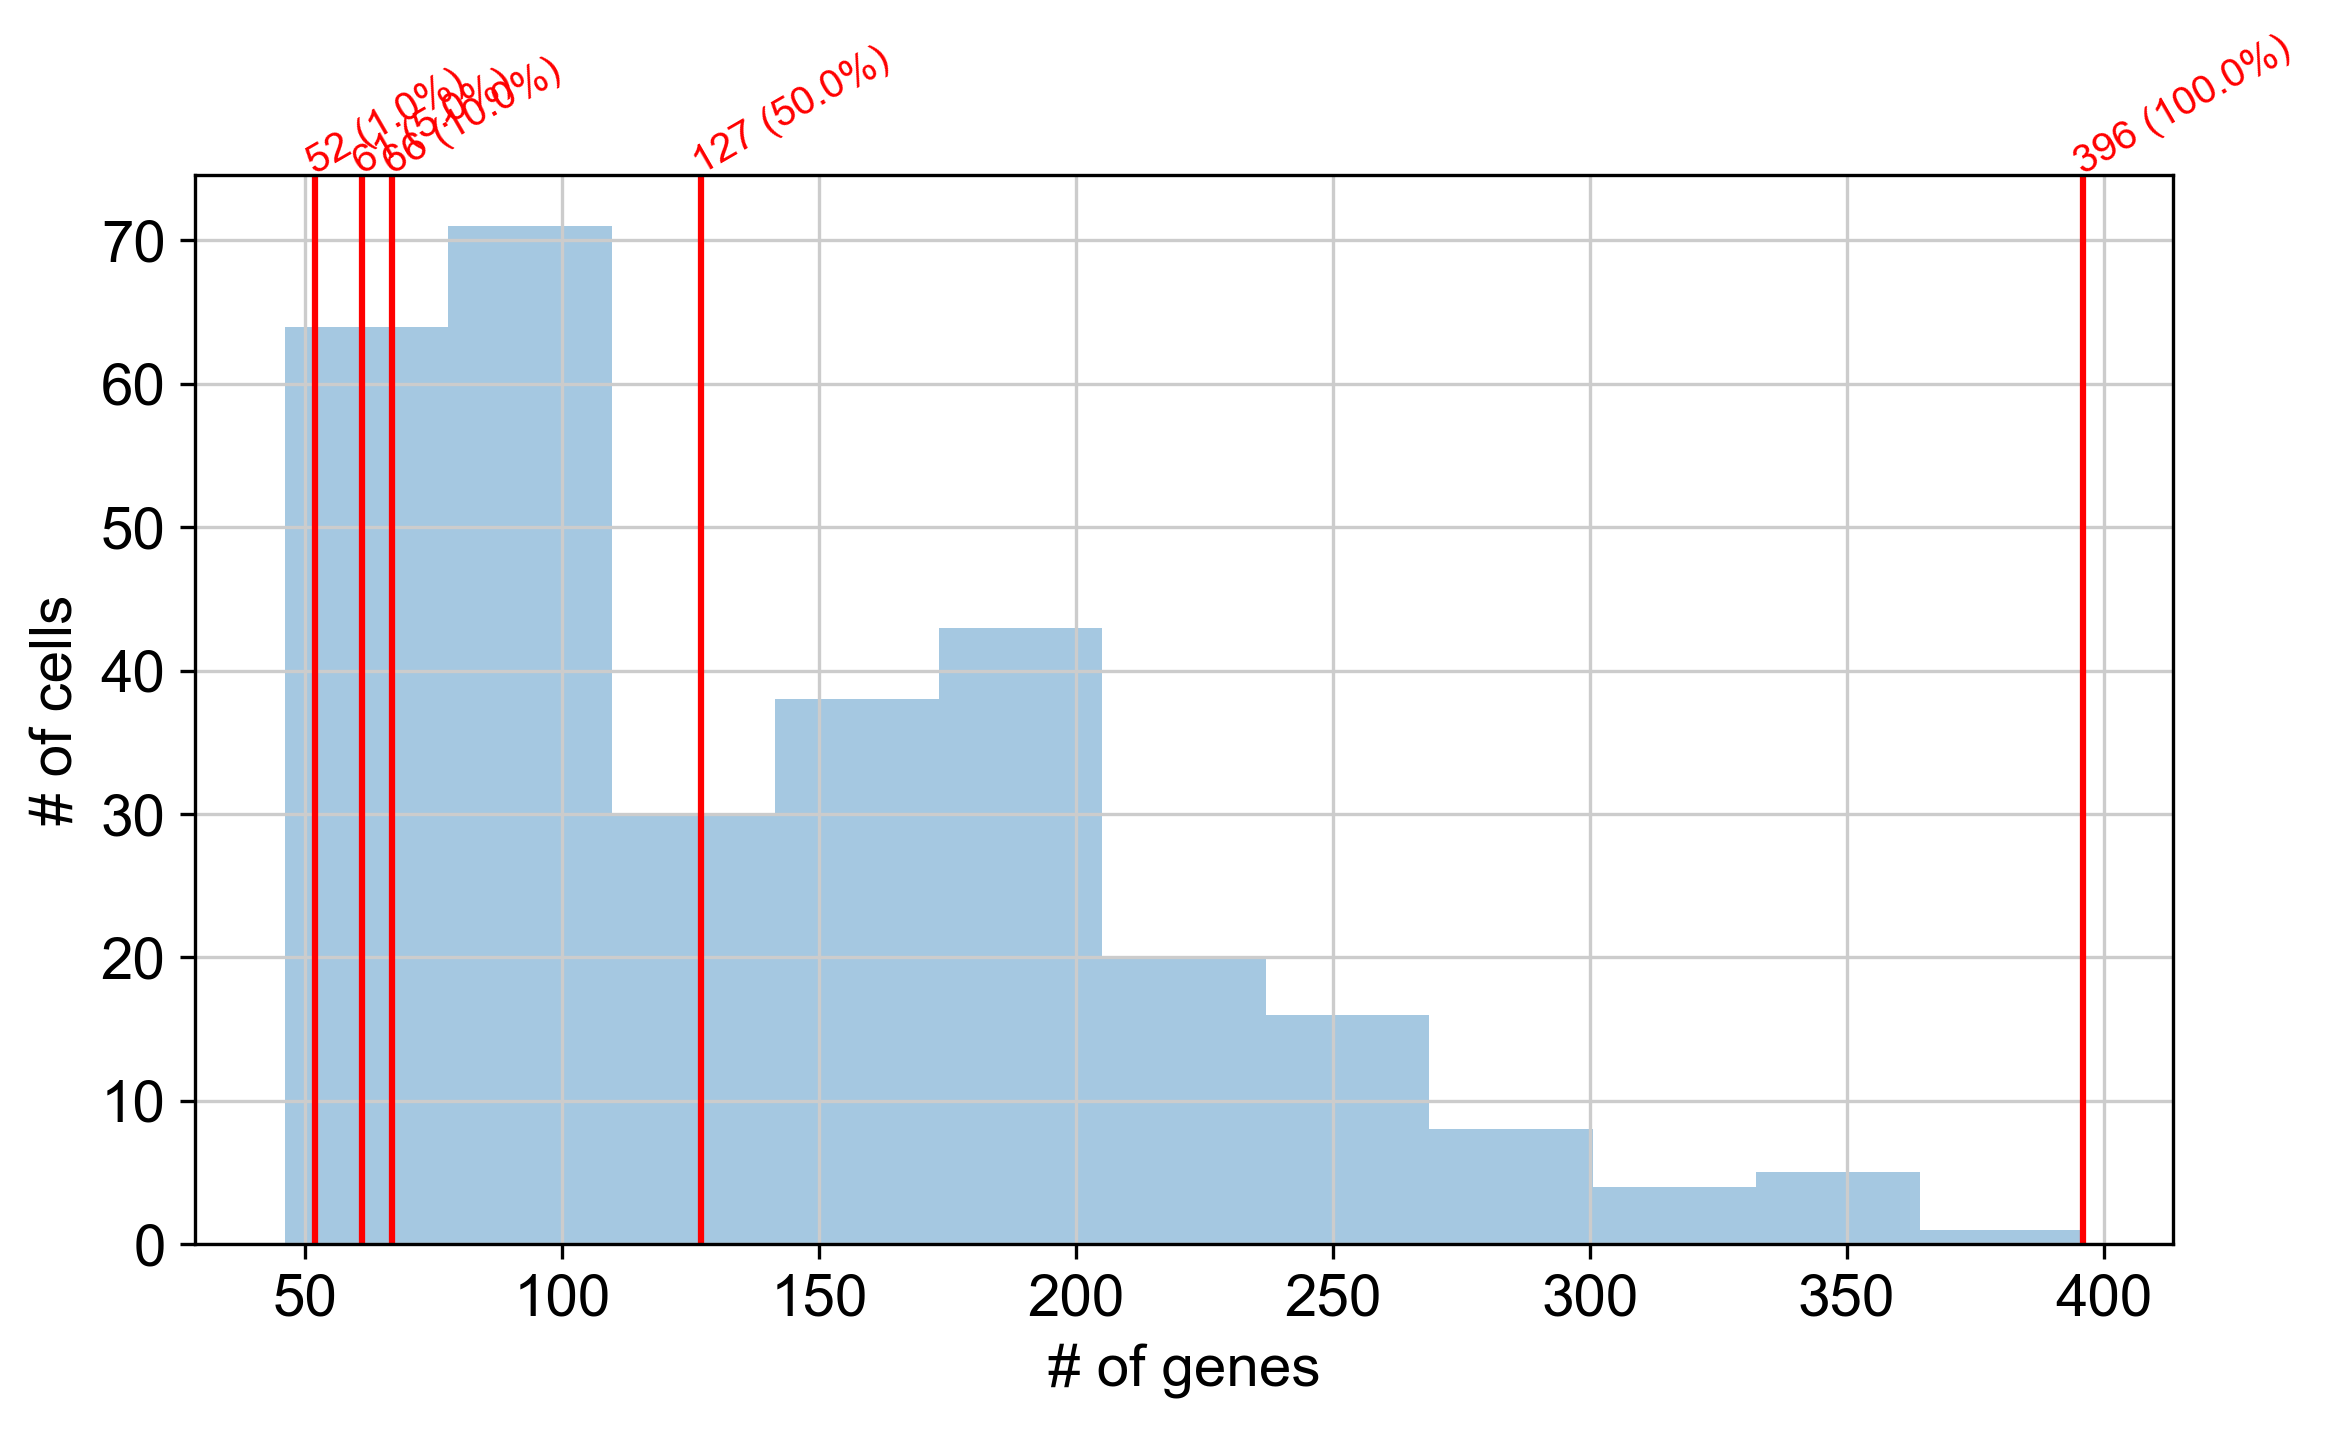

In [41]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC. The following histogram gives an idea of the distribution and allows selection of an appropriate threshold. In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses). See the relevant section in the R tutorial for more information.

By using the default setting for --auc_threshold of 0.05, we see that 1192 genes are selected for the rankings based on the plot below.

This step will use TFs to calculate Area Under the Curve scores, that summarize how well the gene expression observed in each cell can be associated by the regulation of target genes regulatred by the mentioned TFs.

Using the above-generated matrix of cell x TFs and those scores, we can calculate a new embedding using only those.

In [42]:
!pyscenic aucell \
    {loom_path} \
    reg.csv \
    --output {loom_path_output} \
    --num_workers 2


2024-01-16 15:34:10,861 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-01-16 15:34:10,892 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2024-01-16 15:34:11,032 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2024-01-16 15:34:20,439 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/Users/sanketh/opt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


In [43]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect(loom_path_output, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [44]:
import anndata as ad

ad_auc_mtx = ad.AnnData(auc_mtx)
sc.pp.neighbors(ad_auc_mtx, n_neighbors=10, metric="correlation")
sc.tl.umap(ad_auc_mtx)
sc.tl.tsne(ad_auc_mtx)

/Users/sanketh/opt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
rna.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]
rna.obsm["X_tsne_aucell"] = ad_auc_mtx.obsm["X_tsne"]

/var/folders/4n/0z4hxy5s531091hm4l92gjrw0000gn/T/ipykernel_45349/4222269672.py:1: ImplicitModificationWarning: Setting element `.obsm['X_umap_aucell']` of view, initializing view as actual.
  rna.obsm["X_umap_aucell"] = ad_auc_mtx.obsm["X_umap"]


/Users/sanketh/opt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


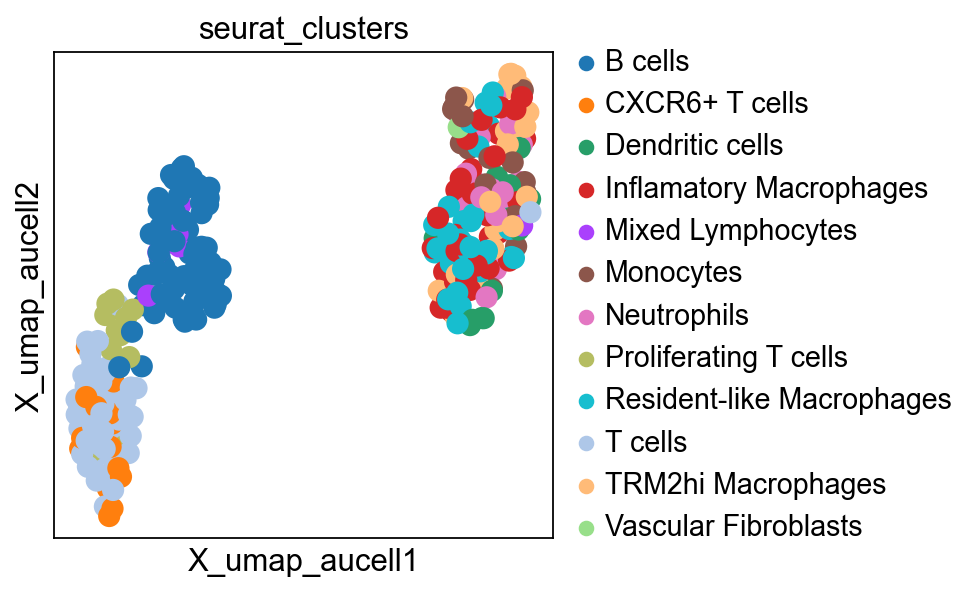

In [46]:
sc.pl.embedding(rna, basis="X_umap_aucell", color="seurat_clusters")

Now running the tsne 

/Users/sanketh/opt/anaconda3/envs/pyscenic_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


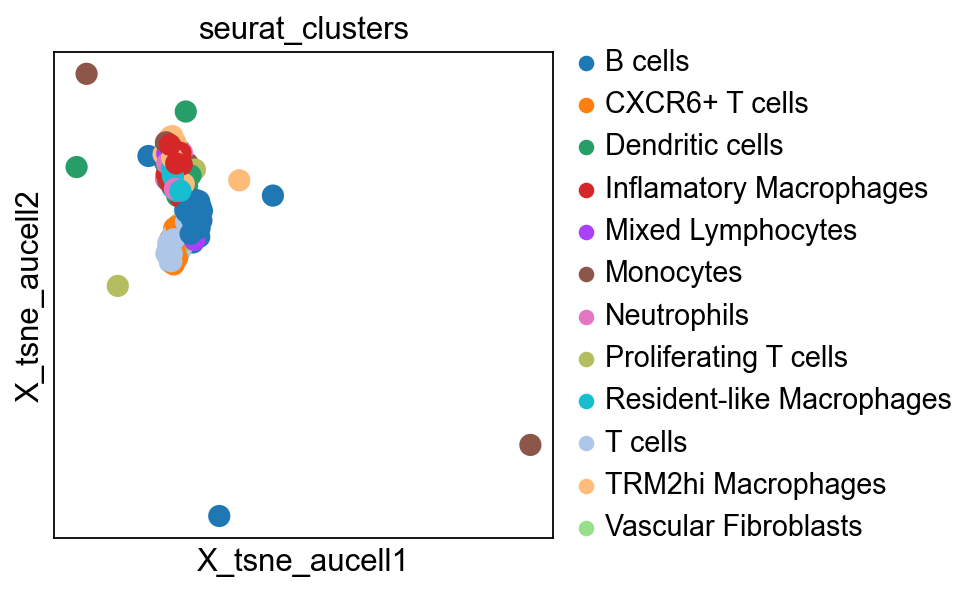

In [49]:
sc.pl.embedding(rna, basis="X_tsne_aucell", color="seurat_clusters")

Heat Map for auc activity :

In [67]:
auc_mtx["seurat_clusters"] = rna.obs["seurat_clusters"]
mean_auc_by_cell_type = auc_mtx.groupby("seurat_clusters").mean()

In [68]:
top_n = 50
top_tfs = mean_auc_by_cell_type.max(axis=0).sort_values(ascending=False).head(top_n)
mean_auc_by_cell_type_top_n = mean_auc_by_cell_type[
    [c for c in mean_auc_by_cell_type.columns if c in top_tfs]
]

Once we know the top TF-regulons involved in the biological system we are studying, we can inspect the activities estimated by each TF, based on the scores per cell, or the overall AUCs per cell-type explained by those TF (blue heatmap below).

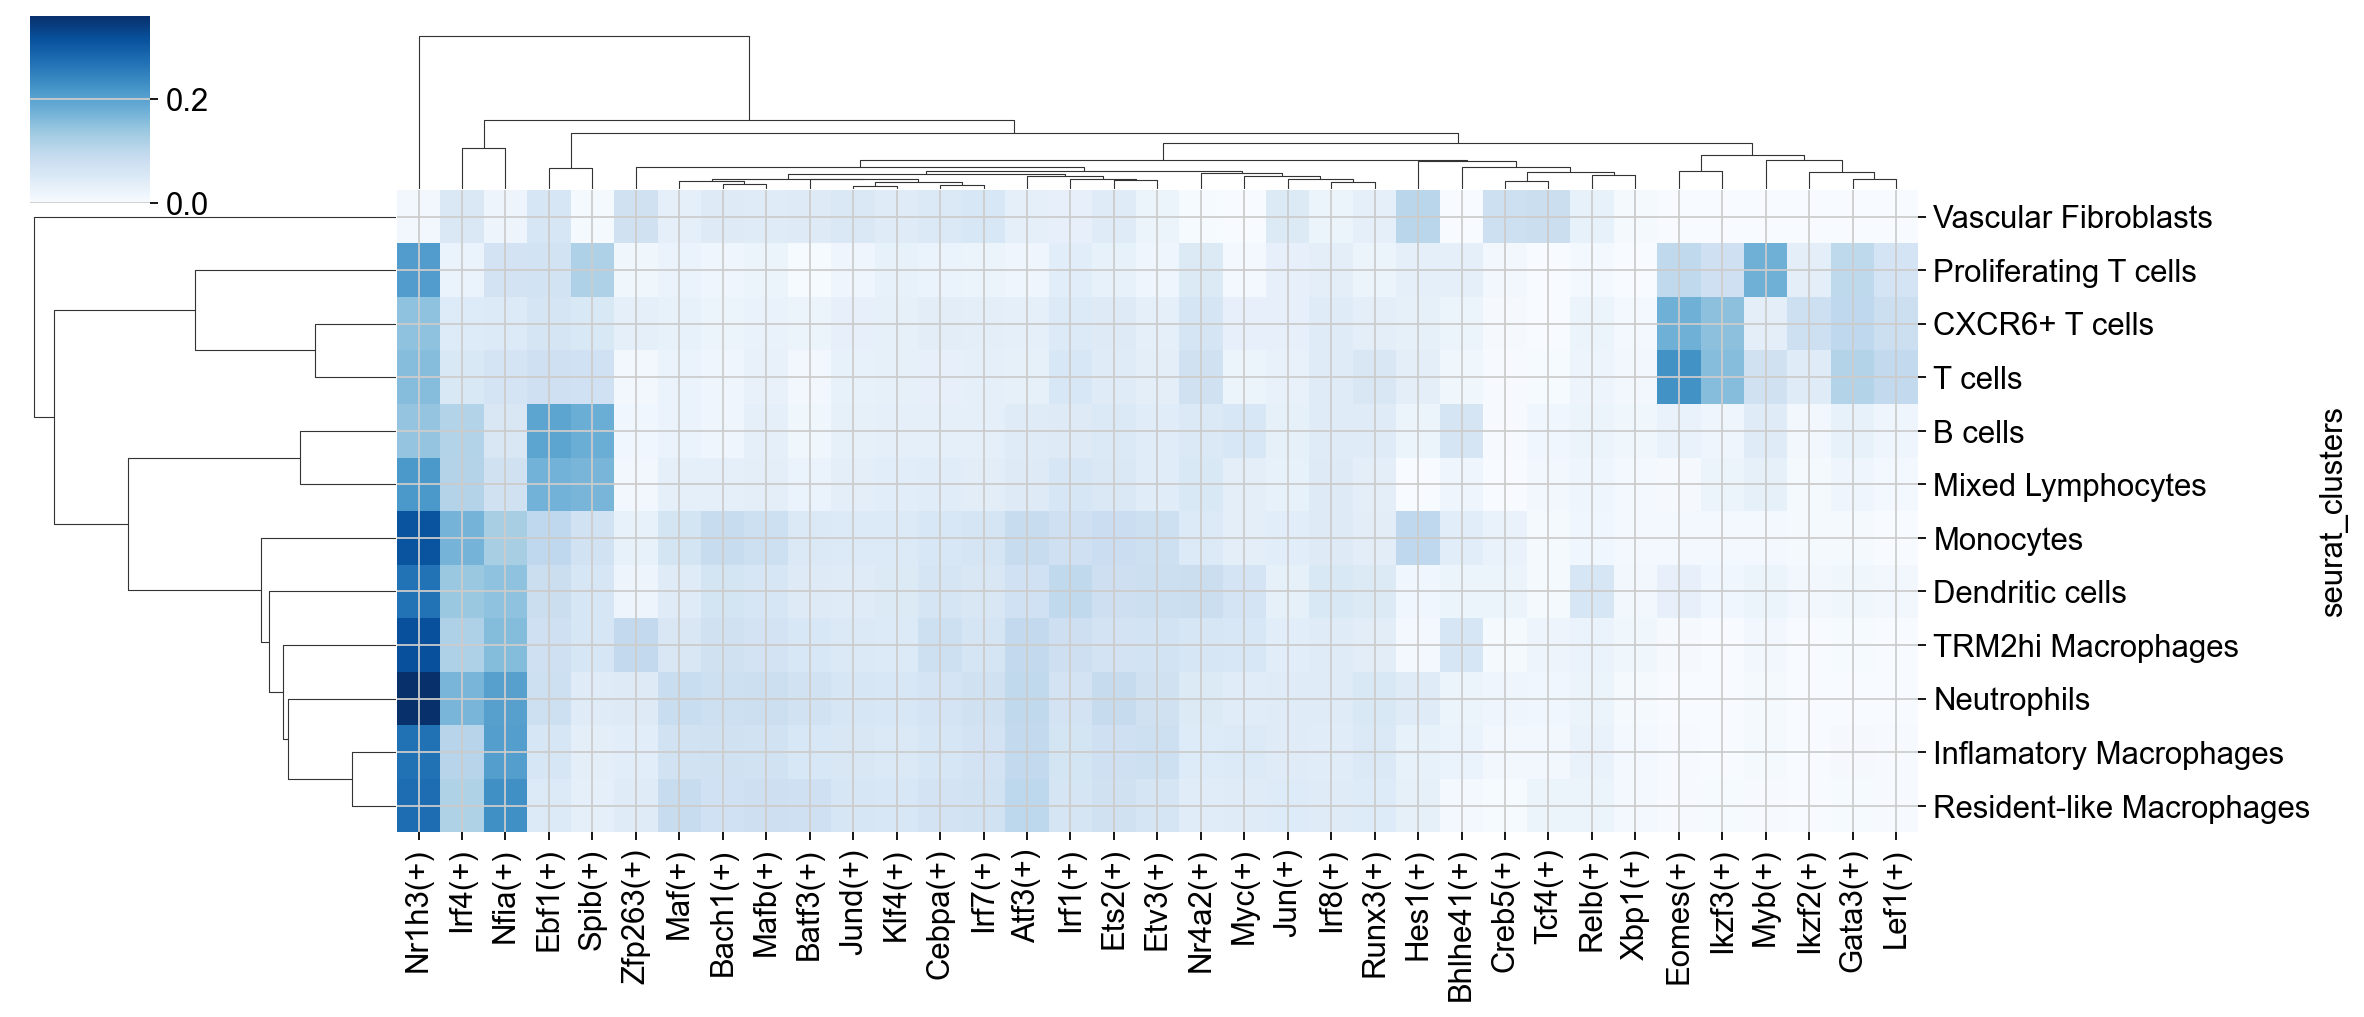

In [69]:
sns.clustermap(
    mean_auc_by_cell_type_top_n,
    figsize=[15, 6.5],
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
)

As the red heatmap is suggesting that some TFs are strongly associated to particular cell types, we can verify the expression of their expression levels as an additional validation. This is done by matching the TF names we want to highlight, and visualize those using Scanpy’s (red heatmap).

In [70]:
tf_names = top_tfs.index.str.replace("\(\+\)", "")
rna_top_tfs = rna[:, rna.var_names.isin(tf_names)]

/var/folders/4n/0z4hxy5s531091hm4l92gjrw0000gn/T/ipykernel_45349/508635316.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  tf_names = top_tfs.index.str.replace("\(\+\)", "")


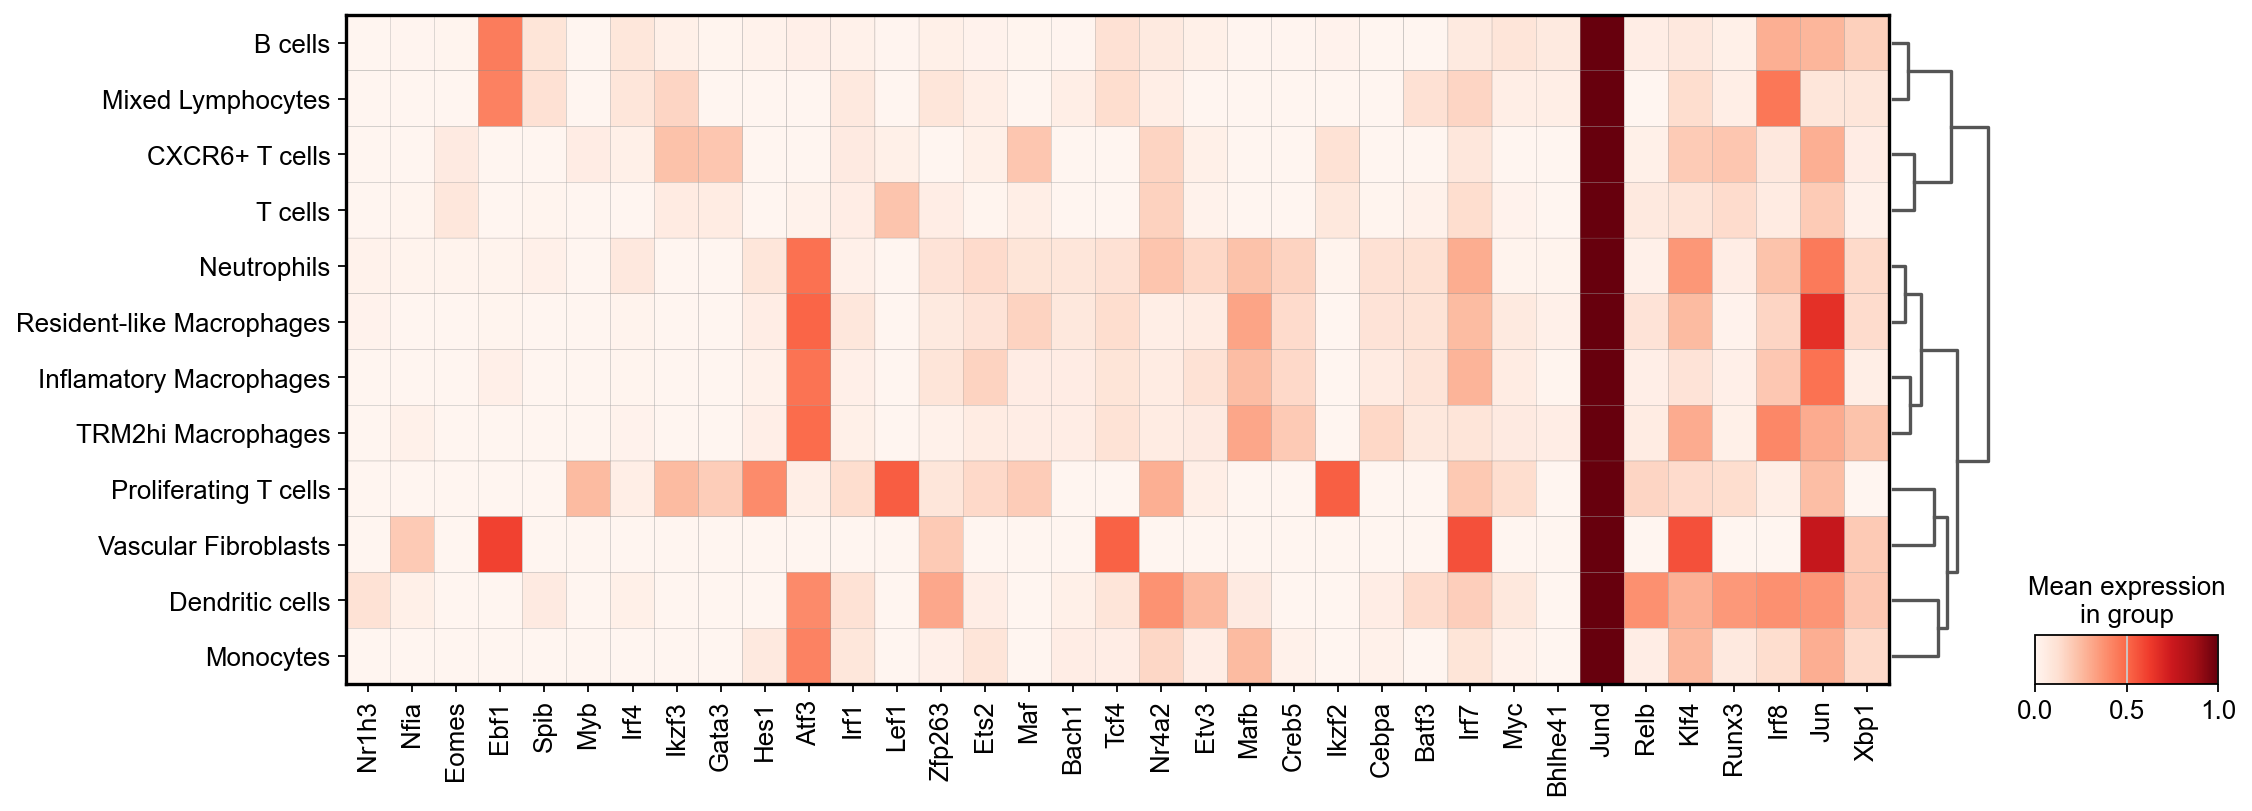

In [71]:
sc.pl.matrixplot(
    rna,
    tf_names,
    groupby="seurat_clusters",
    cmap="Reds",
    dendrogram=True,
    figsize=[15, 5.5],
    standard_scale="group",
)

Reload the loom file as the auc matrix was changed to plot the umap 

In [72]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect(loom_path_output, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

#Getting the umap and saving it 

In [73]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')